# Advanced Preprocessing Pipeline

**Purpose:**
Prepare the EEG dataset for machine learning with advanced techniques:
1.  **Adaptive 'V' Attribute Handling:** Infer types and preprocess accordingly.
2.  **ML-Based Imputation:** Use MICE (IterativeImputer) for accurate filling.
3.  **Prognosis-Centric Feature Selection:** Select top features correlated with prognosis.
4.  **PCA Visualization:** Visualize data structure with prognosis context.

**Output:** A fully processed, scaled, and feature-selected dataset ready for model training.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Advanced Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Plot settings
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 6)

# Paths
DATA_PATH = "data/integrated/"
PROCESSED_PATH = "data/processed/"
OUT_FIGS = globals().get('OUT_FIGS', 'report/figs/')
os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(OUT_FIGS, exist_ok=True)

BASELINE_FILE = "df_baseline_integrated.csv"
LONGITUDINAL_FILE = "df_longit_integrated.csv"

# Helper for figure save and show
def save_and_show(fig, out_fp):
    """Save matplotlib figure with tight layout and show it."""
    fig.tight_layout()
    fig.savefig(out_fp, bbox_inches='tight', dpi=300)
    plt.show()

# Helper for df head show
def safe_head(df, n=5):
    if df is None or df.empty:
        print("DataFrame empty.")
    else:
        display(df.head(n))

# Load Data
print("Loading Data...")
df_baseline = pd.read_csv(os.path.join(DATA_PATH, BASELINE_FILE))
df_longitudinal = pd.read_csv(os.path.join(DATA_PATH, LONGITUDINAL_FILE))

print(f"Baseline Shape: {df_baseline.shape}")
print(f"Longitudinal Shape: {df_longitudinal.shape}")

Loading Data...
Baseline Shape: (82, 624)
Longitudinal Shape: (94, 667)


# 1. Data Cleaning & Transformation

## 1.1. Drop Known Leakage Columns
Removing identifiers and non-predictive metadata information & leakage columns before any processing.

In [2]:
# 1.1 Drop Leakage Columns
leakage_cols_base = ['SubjectNumber', 'Study', 'uniqueID', 'Testbed', 'Headset', 'Visit', 'ABM_stage', 'MCI_score', 'MCI_score_base', 'Condition', 'Condition_V2', 'Age_V2', 'Age_V3']
leakage_cols_long = ['Study','uniqueID', 'Testbed', 'Headset', 'ABM_stage', 'MCI_score_v2', 'MCI_score_diff', 'MCI_diag_thrsld_based_v1','MCI_diag_thrsld_based_v2','MCI_progression_diag_thrsld_based'] 
# Keep SubjectNumber/Visit for pivot

potential_leakage = [c for c in df_baseline.columns if 'comment' in c.lower() or 'date' in c.lower() or 'cond_' in c.lower() or 'cond' in c.lower()]
leakage_cols_base.extend(potential_leakage)
leakage_cols_long.extend(potential_leakage)

df_baseline_clean = df_baseline.drop(columns=[c for c in leakage_cols_base if c in df_baseline.columns], errors='ignore')
df_longitudinal_clean = df_longitudinal.drop(columns=[c for c in leakage_cols_long if c in df_longitudinal.columns], errors='ignore')

# Remove duplicates
df_baseline_clean = df_baseline_clean.drop_duplicates()
df_longitudinal_clean = df_longitudinal_clean.drop_duplicates()

print(f"Baseline Clean Shape: {df_baseline_clean.shape}")
print(f"Longitudinal Clean Shape: {df_longitudinal_clean.shape}")

Baseline Clean Shape: (82, 588)
Longitudinal Clean Shape: (94, 632)


## 1.2. Analyze 'V' Attributes
Inspect columns starting with 'V' to infer their type (Categorical vs Numerical) and preprocess them adaptively.

In [3]:
def analyze_and_process_v_cols(df, name):
    v_cols = [c for c in df.columns if c.startswith('V') and c not in ['Visit']]
    print(f"\nAnalyzing {len(v_cols)} 'V' columns in {name}...")
    
    for col in v_cols:
        unique_vals = df[col].nunique()
        dtype = df[col].dtype
        
        # Heuristic: Low cardinality (<10) -> Categorical, High -> Numerical
        if unique_vals < 10 or dtype == 'object':
            # Treat as Categorical
            # print(f"  [Cat] {col} ({unique_vals} unique)")
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            # Treat as Numerical
            # print(f"  [Num] {col} ({unique_vals} unique)")
            pass # Will be handled by scaler later
            
    return df

df_baseline_clean = analyze_and_process_v_cols(df_baseline_clean, "Baseline")
df_longitudinal_clean = analyze_and_process_v_cols(df_longitudinal_clean, "Longitudinal")


Analyzing 15 'V' columns in Baseline...

Analyzing 15 'V' columns in Longitudinal...


## 1.3. Wide Format Transformation (Longitudinal)
Transforming from 2 rows per subject (V1, V2) to 1 row per subject with `_V1`, `_V2`, and `_Diff` columns.

In [4]:
# 1.3 Wide Format Transformation
id_col = 'SubjectNumber'
visit_col = 'Visit'

if visit_col in df_longitudinal_clean.columns:
    # Pivot numeric columns
    numeric_cols = df_longitudinal_clean.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_pivot = [c for c in numeric_cols if c not in [id_col, visit_col]]
    
    df_wide = df_longitudinal_clean.pivot(index=id_col, columns=visit_col, values=cols_to_pivot)
    df_wide.columns = [f"{col}_V{visit}" for col, visit in df_wide.columns]
    df_wide.reset_index(inplace=True)
    
    base_features = set([c.rsplit('_V', 1)[0] for c in df_wide.columns if c.endswith('_V1')])
    
    diff_data = {}
    
    for feat in base_features:
        v1 = f"{feat}_V1"
        v2 = f"{feat}_V2"
        if v1 in df_wide.columns and v2 in df_wide.columns:
            diff_data[f"{feat}_Diff"] = df_wide[v2] - df_wide[v1]
    
    if diff_data:
        df_diffs = pd.DataFrame(diff_data)
        df_wide = pd.concat([df_wide, df_diffs], axis=1)

    df_wide = df_wide.copy()


    df_longitudinal_clean = df_wide.drop(columns=['SubjectNumber'], errors='ignore')

    # Remove duplicate or unnecessary 'MCI_progression_V2' column to avoid biasing the model
    df_longitudinal_clean = df_longitudinal_clean.drop(columns=['MCI_progression_V2'], errors='ignore')

    # Update the name of column 'MCI_progression_V1' to 'MCI_progression'
    df_longitudinal_clean = df_longitudinal_clean.rename(columns={'MCI_progression_V1': 'MCI_progression'})
    print(f"Wide Format Shape: {df_longitudinal_clean.shape}")
else:
    print("WARNING: Visit column missing, skipping wide format.")

Wide Format Shape: (47, 1835)


# 2. Advanced Missing Value Imputation

Using **IterativeImputer (MICE)** instead of simple mean/median to preserve feature relationships.

In [5]:
def handle_missing_advanced(df, name):
    # Drop 100% missing
    missing = df.isnull().mean()
    drop_cols = missing[missing == 1.0].index.tolist()
    df = df.drop(columns=drop_cols)
    print(f"[{name}] Dropped {len(drop_cols)} empty columns.")
    
    # Impute
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    
    if len(num_cols) > 0:
        print(f"[{name}] Imputing {len(num_cols)} numeric columns with KNNImputer...")
        imp_num = KNNImputer(n_neighbors=5)
        df[num_cols] = imp_num.fit_transform(df[num_cols])
        
    if len(cat_cols) > 0:
        print(f"[{name}] Imputing {len(cat_cols)} categorical columns with Most Frequent...")
        imp_cat = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = imp_cat.fit_transform(df[cat_cols])
        
    return df

from sklearn.impute import SimpleImputer # Needed for categorical
df_baseline_imputed = handle_missing_advanced(df_baseline_clean, "Baseline")
df_longitudinal_imputed = handle_missing_advanced(df_longitudinal_clean, "Longitudinal")

[Baseline] Dropped 12 empty columns.
[Baseline] Imputing 559 numeric columns with KNNImputer...
[Baseline] Imputing 17 categorical columns with Most Frequent...
[Longitudinal] Dropped 30 empty columns.
[Longitudinal] Imputing 1805 numeric columns with KNNImputer...


# 3. Encoding & Scaling

Standard encoding and scaling.

In [6]:
def encode_data(df):
    le = LabelEncoder()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

df_baseline_encoded = encode_data(df_baseline_imputed)
df_longitudinal_encoded = encode_data(df_longitudinal_imputed)

def scale_data(df, target_col=None):
    scaler = StandardScaler()
    if target_col and target_col in df.columns:
        X = df.drop(columns=[target_col])
        y = df[target_col]
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_scaled[target_col] = y.values
        return X_scaled
    else:
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

target_base = 'Diagnosis_base' if 'Diagnosis_base' in df_baseline_encoded else 'Diagnosis'
target_long = 'MCI_progression'
df_baseline_scaled = scale_data(df_baseline_encoded, target_base)
df_longitudinal_scaled = scale_data(df_longitudinal_encoded, target_long)

# 4. Prognosis-Centric Feature Selection & PCA

Selecting Top 5 features correlated with Prognosis and visualizing.

## 4.1. Feature Selection (Correlation with Target)

In [7]:
# 4.1. Feature Selection (Correlation with Target)
def get_top_features(df, target_col, n=5):
    # Filter out constant columns (std=0) to avoid RuntimeWarning (divide by zero)
    # We only keep columns that have a standard deviation greater than 0
    df_varied = df.loc[:, df.std() > 0]

    # Calculate correlations with the target
    corrs = df_varied.corrwith(df[target_col]).abs().sort_values(ascending=False)
    
    # Drop the target column itself from the results
    corrs = corrs.drop(target_col, errors='ignore')
    
    top_features = corrs.head(n).index.tolist()
    print(f"\nTop {n} Features correlated with {target_col}:")
    print(corrs.head(n))
    
    return top_features

top_features = get_top_features(df_longitudinal_scaled, target_long, n=5)
best_feature = top_features[0]


Top 5 Features correlated with MCI_progression:
cluster_1_RSECrel_HCGMCI_Diff     0.608072
cluster_1_3CVTslow_Target_Diff    0.543067
CVT_P1maxPeakLoc_O1_V2            0.523510
CVT_P1avg_C4_Diff                 0.475690
CVT_P100300maxPeak_Pz_Diff        0.461559
dtype: float64


## 4.2. PCA Visualization

PCA Visualization (Hue = cluster_1_RSECrel_HCGMCI_Diff)


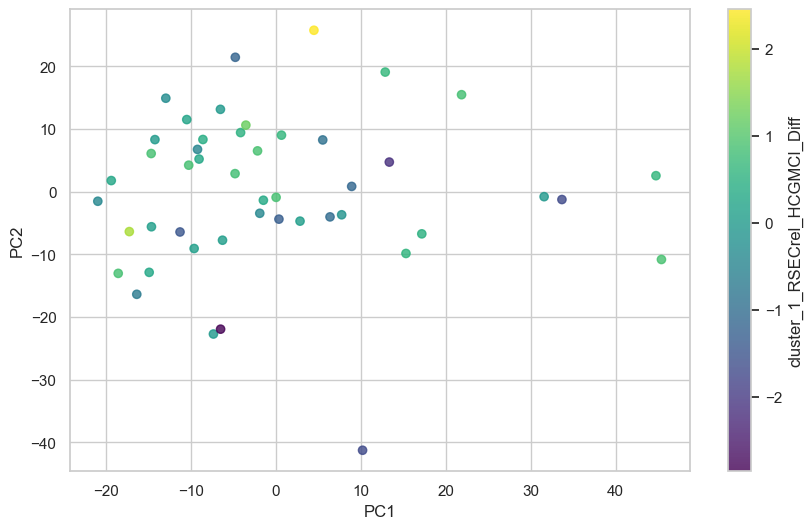

In [8]:
# 4.2. PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_longitudinal_scaled.drop(columns=[target_long], errors='ignore'))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_longitudinal_scaled[best_feature], cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label=best_feature)
print("PCA Visualization (Hue = {})".format(best_feature))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 5. Summary & Save

Saving the final processed datasets.

In [9]:
baseline_out = os.path.join(PROCESSED_PATH, "df_baseline_processed.csv")
longitudinal_out = os.path.join(PROCESSED_PATH, "df_longitudinal_processed.csv")

df_baseline_scaled.to_csv(baseline_out, index=False)
df_longitudinal_scaled.to_csv(longitudinal_out, index=False)

print(f"Saved Final Baseline: {df_baseline_scaled.shape}")
print(f"Saved Final Longitudinal: {df_longitudinal_scaled.shape}")

Saved Final Baseline: (82, 576)
Saved Final Longitudinal: (47, 1805)
